TokaMaker Example: Simple equilibrium in HBT-EP {#doc_tMaker_HBT_ex2}
==========
In this example we show how to compute simple equilibria in HBT-EP:
 1. The "inverse" case where we have a desired shape, plasma current and pressure, but the required coil currents are unkown
 2. The "forward" case where we have already have coil currents, plasma current, and known position for the desired equilibrium

This example utilizes the mesh built in \ref doc_tMaker_HBT_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun

## Compute equilibria

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   v1_beta6
Revision id:          681e857
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_64655/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_HBT_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('HBT_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0=0.2518*1.23) # F0 = B0 * R0


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.278E+00
    # of points  =    3736
    # of edges   =   11087
    # of cells   =    7352
    # of boundary points =     118
    # of boundary edges  =     118
    # of boundary cells  =     118
  Resolution statistics:
    hmin =  1.959E-04
    hrms =  3.418E-02
    hmax =  9.532E-02
  Surface grounded at vertex     804


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.4220000000000001E-003


### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". For HBT-EP, a limit of 20 kA/turn is set for the OH with 15 kA/turn for the VF and SH.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [5]:
coil_bounds = {}
for name in mygs.coil_sets:
    if name.startswith('OH'):
        bounds = [-2.00E+04,2.00E+04]
    elif name.startswith('VF'):
        bounds = [-1.50E+04,4.20E+04]
    elif name.startswith('SH'):
        bounds = [-1.50E+04,1.50E+04]
    coil_bounds[name] = np.array(bounds)
    
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current (`Ip`) and the ratio of the contribtions of $ F*F' $ and $ P' $ to $ I_p $, which can be considered a proxy for $ \beta_p $.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [6]:
Ip_target = 11928.5

mygs.set_targets(Ip=Ip_target, Ip_ratio=0.02)

### Define shape targets
As HBT-EP has only a few coil sets there is limited shaping that is available. For the first case we just generate a standard circular plasma at a fixed location using `isoflux` points to set the rough radial and vertical bounds of the LCFS.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

In [7]:
isoflux_pts = np.array([
    [107.0, 0.0],
    [93.0, 14.0],
    [78.0, 0.0],
    [93.0, -14.0]
])/100.0

mygs.set_isoflux(isoflux_pts)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the coils. In TokaMaker these regularization terms have the general form, where each term corresponds to a set of coil coefficients, target value, and weight. The \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_reg_term "coil_reg_term()" method is provided to aid in defining these terms.

Here we use the identity as the regularization matrix:
 1. A target of 0 A and a *modest* weight for the `VF` coil
 2. A target of -8 kA and a *high* weight for the `OH` coil
 3. A target of 0 A and a *high* weight for the `SH` coil

The first regularization term weakly penalizes current in the `VF` coil to prevent large currents. While this is not strictly required in a simple case like HBT-EP it is generally necessary in configurations with more coils and higher shaping.

The second and third terms use high weights to force (approximately) the current in the `OH` and `SH` coils to -8 kA and 0 kA respectively.

In [8]:
# Set regularization weights
regularization_terms = [
    mygs.coil_reg_term({'VF': 1.0},target=0.0,weight=1.E-1),
    mygs.coil_reg_term({'OH': 1.0},target=-8.E3,weight=1.E3),
    mygs.coil_reg_term({'SH': 1.0},target=0.0,weight=1.E3),
]

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, using \ref OpenFUSIONToolkit.TokaMaker.util.create_power_flux_fun "create_power_flux_fun()", where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

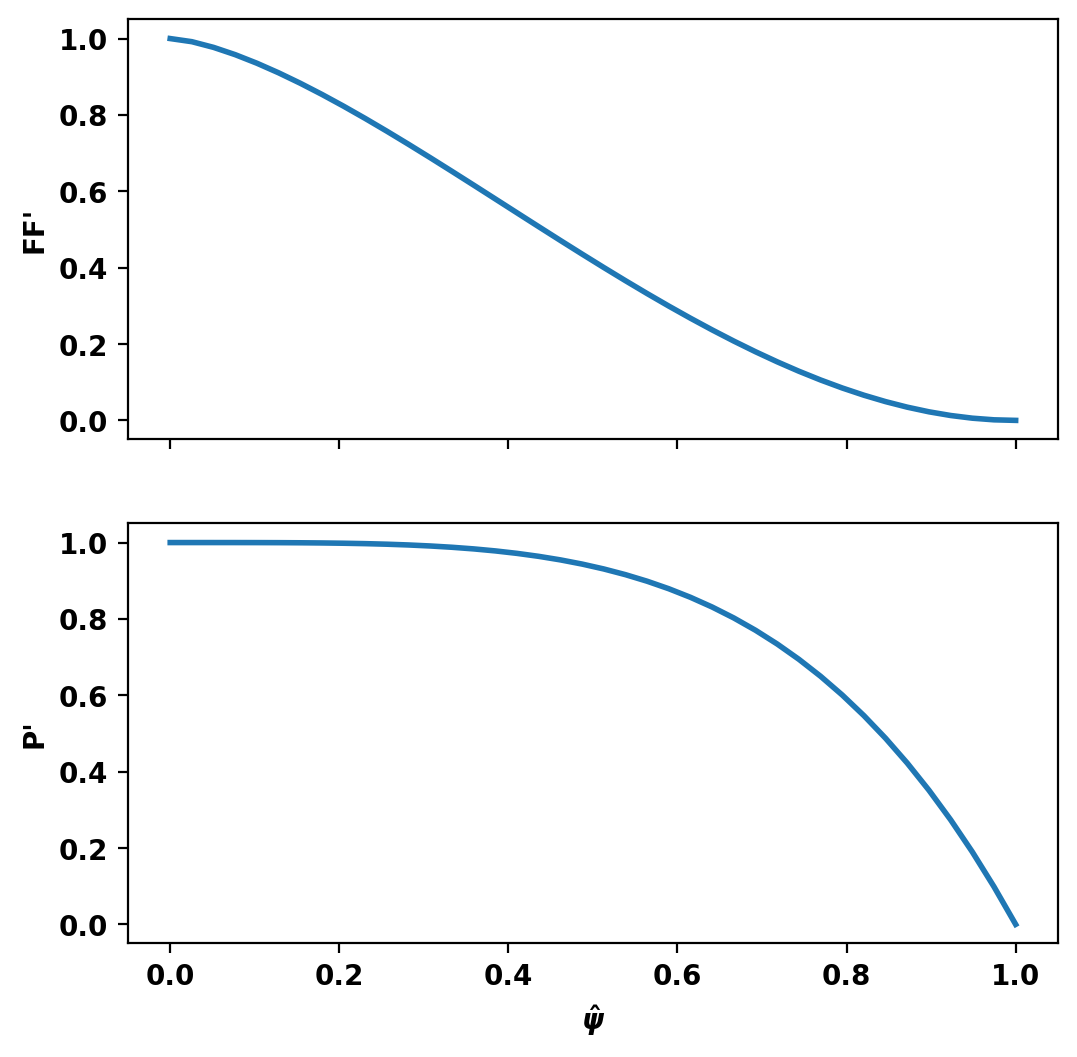

In [9]:
# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [10]:
R0 = 0.92
Z0 = 0.0
a = 0.15
kappa = 1.0
delta = 0.0
mygs.init_psi(R0, Z0, a, kappa, delta)
mygs.solve()

Starting non-linear GS solver
     1  1.9399E-02  3.1501E-01  3.0188E-04  9.3857E-01 -1.7715E-05 -0.0000E+00
     2  2.0101E-02  3.2139E-01  8.0636E-05  9.3962E-01 -1.6011E-05 -0.0000E+00
     3  2.0301E-02  3.2316E-01  2.2287E-05  9.3989E-01 -2.6169E-05 -0.0000E+00
     4  2.0365E-02  3.2372E-01  6.5134E-06  9.3998E-01 -3.1799E-05 -0.0000E+00
     5  2.0387E-02  3.2390E-01  1.9972E-06  9.4000E-01 -3.7284E-05 -0.0000E+00
     6  2.0394E-02  3.2396E-01  6.3248E-07  9.4001E-01 -4.2616E-05 -0.0000E+00
 Timing:   3.6635000025853515E-002
   Source:     1.7673000053036958E-002
   Solve:      1.1245999950915575E-002
   Boundary:   1.1719999602064490E-003
   Other:      6.5440000616945326E-003


### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

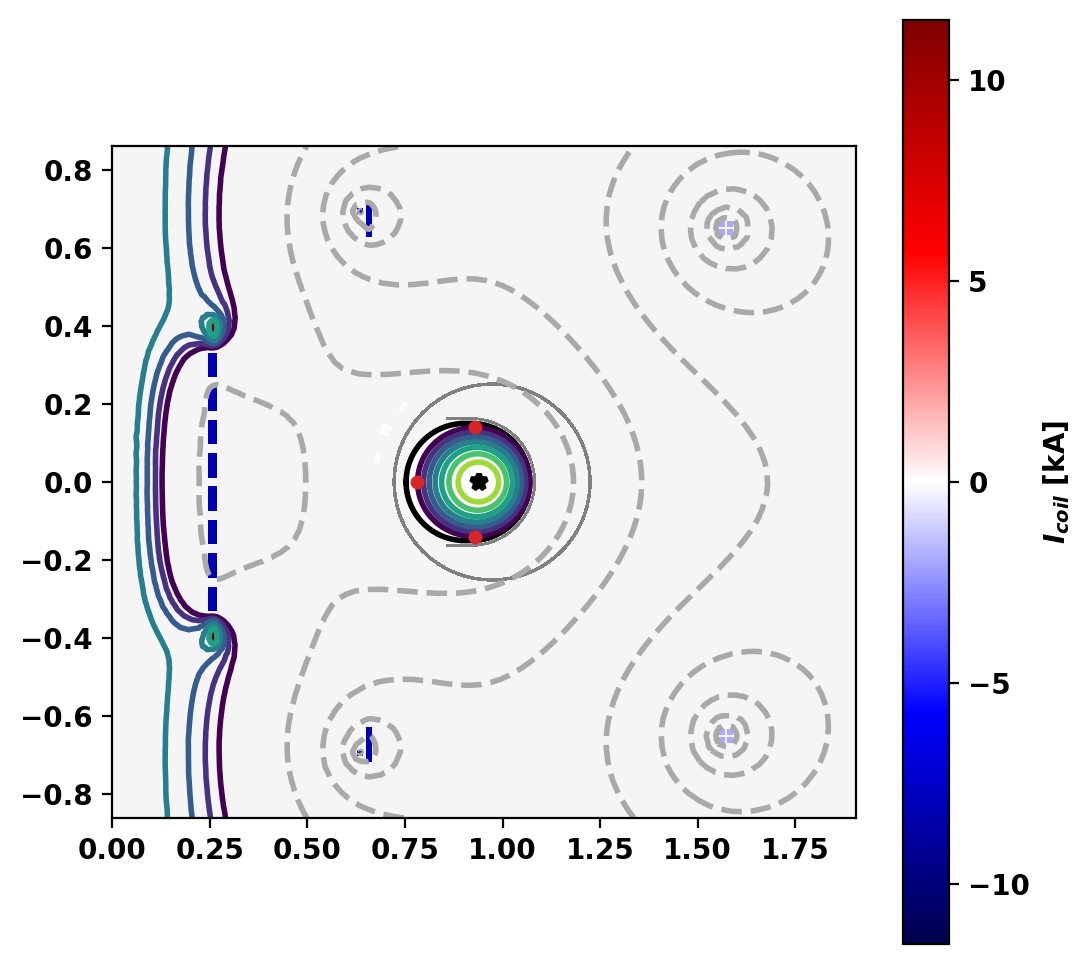

In [11]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=8)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method, which are all within the approximate coil limits imposed above.

In [12]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    print('  {0:10} {1:10.2F}'.format(key+":",current/1.E3))

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.1928E+04
  Current Centroid [m]    =    0.933 -0.000
  Magnetic Axis [m]       =    0.940 -0.000
  Elongation              =    0.968 (U:  0.968, L:  0.968)
  Triangularity           =    0.003 (U: -0.003, L:  0.010)
  Plasma Volume [m^3]     =    0.365
  q_0, q_95               =    2.227  2.981
  Plasma Pressure [Pa]    =   Axis:  2.8217E+02, Peak:  2.8217E+02
  Stored Energy [J]       =    6.1610E+01
  <Beta_pol> [%]          =   99.1571
  <Beta_tor> [%]          =    0.2526
  <Beta_n>   [%]          =    1.0171
  Diamagnetic flux [Wb]   =    3.6725E-07
  Toroidal flux [Wb]      =    2.1126E-02
  l_i                     =    0.7131

Coil Currents [kA]:
  OH:             -8.00
  VF:             -1.92
  SH:              0.00


## Compute forward equilibrium with shaping

### Update global quantities and targets
For the forward case we re-define a target for the plasma current (`Ip`) and swap the `Ip_ratio` target for an `R0` target, which constrains the location of the magnetic axis.

We also remove the isoflux targets so that the coil currents will remained fixed during the solve.

In [13]:
mygs.set_targets(Ip=Ip_target,R0=0.94)
mygs.set_isoflux(None)

### Set coil currents explicitly
Here we update the coil currents, which were retrieved above, to put current in the shaping coil (`SH`). Additionally, we slightly adjust current in the `VF` to produce a plasma with reasonable $\beta_p$. Values are updated by passing an updated array to \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents "set_coil_currents()".

In [14]:
coil_currents['VF'] = -1.65E3
coil_currents['SH'] = -7.E3
mygs.set_coil_currents(coil_currents)

### Solve for updated equilibrium
As this solve is somewhat more challenging we increase the maximum number of solver iterations using the \ref OpenFUSIONToolkit.TokaMaker.tokamaker_settings_struct "settings" object and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.update_settings "update_settings()".

In [15]:
mygs.settings.maxits = 60
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.8362E-01  2.7213E-01  1.7497E-03  9.4000E-01  4.9598E-04  0.0000E+00
     2  3.3455E-01  2.6822E-01  3.5215E-04  9.3998E-01  1.1622E-03  0.0000E+00
     3  4.8616E-01  2.5806E-01  7.2479E-05  9.3996E-01  1.8002E-03  0.0000E+00
     4  5.8778E-01  2.4105E-01  1.7202E-05  9.3996E-01  2.4049E-03  0.0000E+00
     5  6.5441E-01  2.2767E-01  7.0824E-06  9.3996E-01  2.9794E-03  0.0000E+00
     6  6.9651E-01  2.1901E-01  4.9237E-06  9.3996E-01  3.5262E-03  0.0000E+00
     7  7.2257E-01  2.1389E-01  4.0626E-06  9.3996E-01  4.0498E-03  0.0000E+00
     8  7.3765E-01  2.1135E-01  3.5890E-06  9.3996E-01  4.5508E-03  0.0000E+00
     9  7.4649E-01  2.1023E-01  3.3133E-06  9.3996E-01  5.0314E-03  0.0000E+00
    10  7.5152E-01  2.1000E-01  3.1344E-06  9.3997E-01  5.4934E-03  0.0000E+00
    11  7.5418E-01  2.1031E-01  3.0002E-06  9.3997E-01  5.9389E-03  0.0000E+00
    12  7.5538E-01  2.1094E-01  2.8838E-06  9.3997E-01  6.3688E-03  0.0000E+00
    13  7.5569E-01  2.

### Plot equilibrium

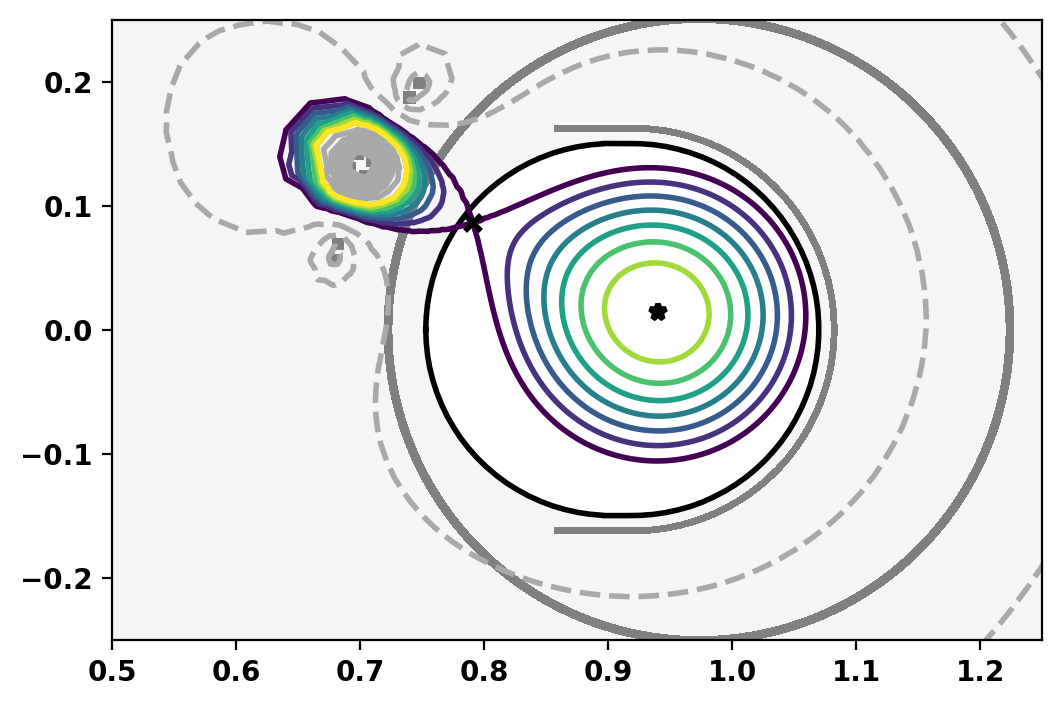

In [16]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,xpoint_color='k')
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')
ax.set_ylim(-0.25,0.25)
_ = ax.set_xlim(0.5,1.25)

### Print equilibrium information and coil currents

In [17]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    print('  {0:10} {1:10.2F}'.format(key+":",current/1.E3))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.1921E+04
  Current Centroid [m]    =    0.936  0.015
  Magnetic Axis [m]       =    0.940  0.014
  Elongation              =    0.879 (U:  0.866, L:  0.893)
  Triangularity           =   -0.086 (U: -0.062, L: -0.109)
  Plasma Volume [m^3]     =    0.281
  q_0, q_95               =    1.159  2.305
  Plasma Pressure [Pa]    =   Axis:  2.4719E+02, Peak:  2.4719E+02
  Stored Energy [J]       =    3.7206E+01
  <Beta_pol> [%]          =   63.1048
  <Beta_tor> [%]          =    0.1976
  <Beta_n>   [%]          =    0.7462
  Diamagnetic flux [Wb]   =    1.0665E-05
  Toroidal flux [Wb]      =    1.6102E-02
  l_i                     =    0.9748

Coil Currents [kA]:
  OH:             -8.00
  VF:             -1.65
  SH:             -7.00
